In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget
matplotlib.rc('font', size=18)
import os
import uncertainties as unc
import scipy.special as ss

from tqdm.notebook import tqdm

import sys
sys.path.append('../')
import general_purpose.utilities as ut
import general_purpose.uplotlib as uplt

from importlib import reload

import rea.reconstruct as rec

In [2]:
def get_run(folder, iteration=None):
    if iteration is None:
        try:
            run = {'folder': folder, 'rec_dict': ut.json2dict(f'{folder}/reconstructed.json')}
        except FileNotFoundError:
            # detect last iteration
            iterations = [int(f[1:]) for f in os.listdir(folder) if f[0] == 'i']
            iteration = np.max(iterations)
            run = {'folder': folder, 'rec_dict': rec.reconstruct(f'{folder}/i{iteration:04d}')}
            ut.dict2json(run['rec_dict'], f'{folder}/reconstructed.json')
    else:
        run = {'folder': folder, 'rec_dict': rec.reconstruct(f'{folder}/i{iteration:04d}')}
    
    run['abs_observables'] = {}
    run['rel_observables'] = {}
    for rname, r in run['rec_dict']['members'].items():
        last_segment_traj = np.load(f"{folder}/{run['rec_dict']['folders'][-1]}/{r['ancestry'][-1]}-traj.npy")
        first_segment_traj = np.load(f"{folder}/{run['rec_dict']['folders'][0]}/{r['ancestry'][0]}-traj.npy")
        run['abs_observables'][rname] = last_segment_traj[-1,1]
        run['rel_observables'][rname] = last_segment_traj[-1,1] - first_segment_traj[0,1]
        
    first_segment_traj = np.load(f"{folder}/{run['rec_dict']['folders'][0]}/{r['ancestry'][0]}-traj.npy")
    run['duration'] = last_segment_traj[-1,0] - first_segment_traj[0,0]
        
    return run

def compute_trajectories(run):
    folder = run['folder']
    rec_dict = run['rec_dict']
    rec_trajs = {}

    for rname, r in tqdm(rec_dict['members'].items()):
        traj = []
        for subfolder,e in zip(rec_dict['folders'], r['ancestry']):
            traj.append(np.load(f'{folder}/{subfolder}/{e}-traj.npy'))
        traj = np.concatenate(traj)

        rec_trajs[rname] = traj
    
    run['traj'] = rec_trajs
    
    return rec_trajs

def plot_traj(run, start=0, **kwargs):
    if 'traj' not in run:
        compute_trajectories(run)
    for traj in run['traj'].values():
        plt.plot(traj[start:,0]-traj[0,0], -traj[start:,1], **kwargs)

def expectation(run, func, mode='abs', **kwargs):
    _f = np.array([func(x, **kwargs) for x in run[f'{mode}_observables'].values()])
    _w = np.array([r['weight'] for r in run['rec_dict']['members'].values()])
    # _w = np.exp(-np.array([r['cum_log_escore'] for r in rec_dict['members'].values()]))
    # _n = np.exp(rec_dict['cum_log_norm_factor'])

    mean = np.mean(_f*_w)
    std = np.sqrt(np.mean((_f*_w)**2)/len(_w))

    return unc.ufloat(mean,std)

def f(x, a):
    return float(x>a)

def get_infos(folder):
    i = 0
    infos = {}
    while True:
        try:
            infos[i] = ut.json2dict(f'{folder}/i{i:04d}/info.json')
            i += 1
        except FileNotFoundError:
            break
            
    return infos


In [3]:
# folder = '../veros/__test__/r3_minimal'
# folder = '../veros/__test__/r2_minimal'
# folder = '../veros/__test__/r01--k__16--nens__50--T__5_minimal'
# folder = '../veros/__test__/rA-k20t50_minimal'

# folder = '../veros/__test__/rf1_minimal'
# folder = '../veros/__test__/rk50_minimal'
# folder = '../veros/__test__/rk1000t5_minimal'

# folder = '../veros-temp-noise-old/__test__/rn-k10t5_minimal'
# folder = '../veros-temp-noise-old/__test__/rn-k20t5_minimal'
# folder = '../veros-temp-noise-old/__test__/rn-k30t5_minimal'
# folder = '../veros-temp-noise-old/__test__/rn-k10t10_minimal'
# folder = '../veros-temp-noise-old/__test__/rn-k10t20_minimal'

# folder = '../veros-temp-noise/__test__/rN-k10t5_minimal'
# folder = '../veros-temp-noise/__test__/rAN-k10t5_minimal'

# folder = '../veros-temp-noise/__test__/rAAtlN-k20t10_minimal'
# folder = '../veros-temp-noise/__test__/rAAtlN_s1-k20t25_minimal'
# folder = '../veros-temp-noise/__test__/rAAtlN_s1-k20_minimal'

# folder = '../veros-temp-noise/__test__/rY1AAtlN-k10t1_minimal'
# folder = '../veros-temp-noise/__test__/rY1AAtlN-k20t1_minimal'
# folder = '../veros-temp-noise/__test__/rY1AAtlN-k30t1_minimal'

folder = '../veros-temp-noise/__test__/rLyapY1k1000t50_minimal'

## Trajectory

In [4]:
run = get_run(folder)
_ = compute_trajectories(run)

  0%|          | 0/10 [00:00<?, ?it/s]

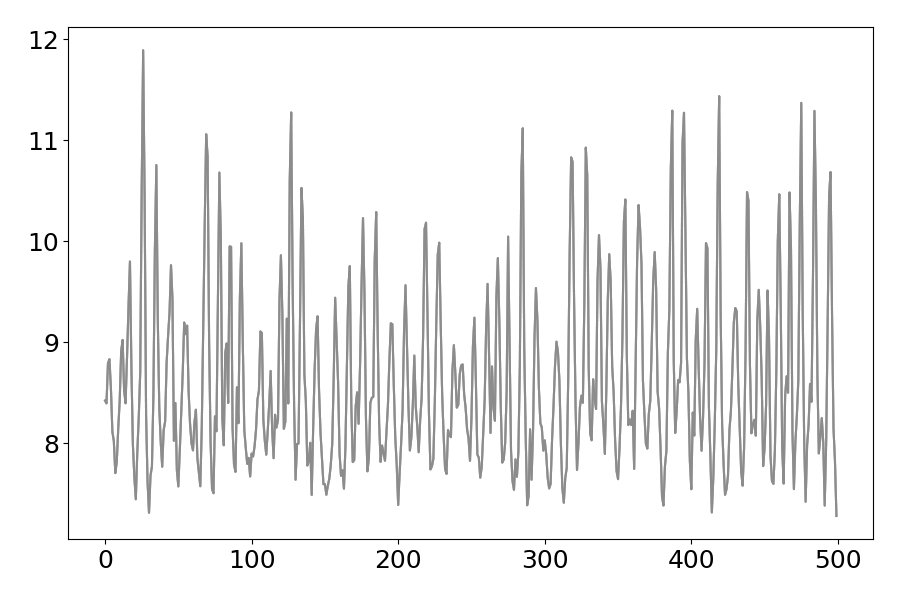

In [5]:
plt.close(1)
fig,ax = plt.subplots(figsize=(9,6), num=1)

plot_traj(run, color='gray', alpha=0.2,
          # marker='o'
         )

fig.tight_layout()

## Probabilities

In [ ]:
iterations = [5,10,15,20]
runs = [get_run(folder, iteration=i) for i in iterations]

In [ ]:
mode = 'abs'
# mode = 'rel'

plt.close(1)
fig,ax = plt.subplots(num=1, figsize=(9,6))

min_obs = np.infty
max_obs = -np.infty

for run in runs:
    m = np.min(list(run[f'{mode}_observables'].values()))
    M = np.max(list(run[f'{mode}_observables'].values()))
    if m < min_obs:
        min_obs = m
    if M > max_obs:
        max_obs = M
    plt.scatter([run['duration'] + 5]*2, [m, M], color='black')

fig.tight_layout()

print(f'{min_obs = }, {max_obs = }')

In [ ]:
a = np.linspace(min_obs, max_obs, 101)
es = np.array([[expectation(run, f, a=_a, mode=mode) for _a in a] for run in runs])

In [ ]:
plt.close(11)
fig,ax = plt.subplots(num=11, figsize=(9,6))

for i,run in enumerate(runs):
    uplt.errorband(-a, es[i], label=f"After {run['duration'] + 5:.0f} years")
    
plt.yscale('log')
# plt.ylim(1e-6,3)
plt.axhline(1, color='black', linestyle='dashed')

if mode == 'abs':
    plt.xlabel('AMOC strength [Sv]')
else:
    plt.xlabel('AMOC strength difference [Sv]')

plt.ylabel('probability')

plt.legend()

fig.tight_layout()

## Time-probability plot

In [6]:
nits = int(run['rec_dict']['last_folder'][1:])
print(f'detected {nits} iterations')
iterations = np.arange(nits) + 1
runs = [get_run(folder, iteration=i) for i in iterations]

DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE


detected 10 iterations


min_obs = -7.928718965315981, max_obs = -7.280768187827452


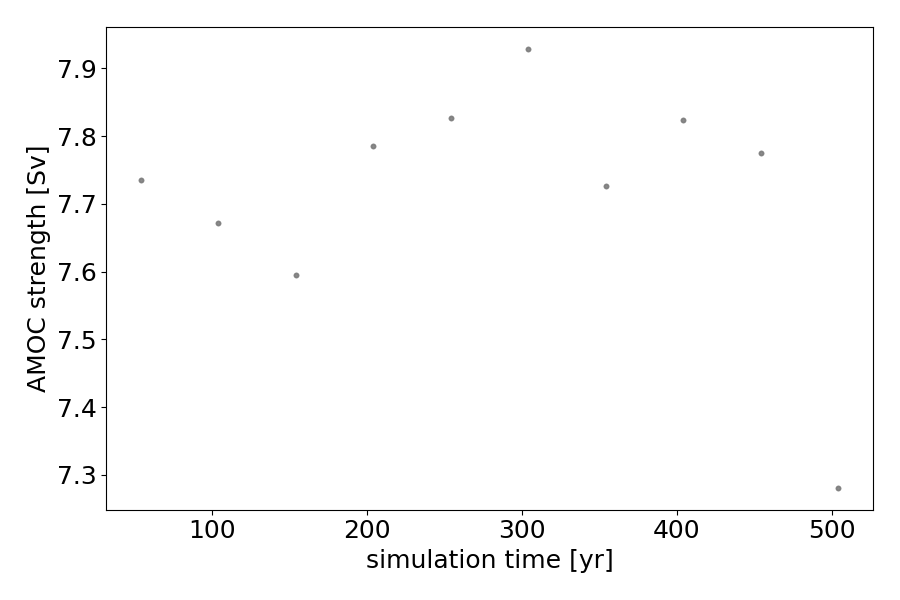

In [7]:
mode = 'abs'
# mode = 'rel'

plt.close(2)
fig,ax = plt.subplots(num=2, figsize=(9,6))

min_obs = np.infty
max_obs = -np.infty

for run in runs:
    obs = np.array(list(run[f'{mode}_observables'].values()))
    dur = run['duration'] + 5
    m = np.min(obs)
    M = np.max(obs)
    if m < min_obs:
        min_obs = m
    if M > max_obs:
        max_obs = M
    # plt.scatter([run['duration'] + 5], [-M], color='blue')
    # plt.scatter([run['duration'] + 5], [-m], color='red')
    
    plt.scatter([dur]*len(obs), -obs, alpha=0.2, color='gray', marker='.')

plt.xlabel('simulation time [yr]')
plt.ylabel('AMOC strength' + (' difference' if mode == 'rel' else '') + ' [Sv]')
fig.tight_layout()

print(f'{min_obs = }, {max_obs = }')

In [ ]:
min_obs = -8.5
max_obs = -7.5

In [ ]:
a = np.linspace(min_obs, max_obs, 101)

In [ ]:
dur = np.array([run['duration'] + 5 for run in runs])
es = np.array([[expectation(run, f, a=_a, mode=mode) for _a in a] for run in runs])

In [ ]:
plt.close(2)
fig,ax = plt.subplots(num=2, figsize=(9,6))

min_es = uplt.nominal_value(np.min(es[es > 0]))
print(min_es)
first_lev = np.floor(np.log10(min_es))

plt.contourf(-a, dur, np.log10(uplt.nominal_value(es) + 10**(first_lev - 1)),
             # levels=np.linspace(-4,0,9),
             levels = np.arange(first_lev,0.2, 0.5),
             # cmap='Greys_r',
             cmap='inferno',
             extend='both')

plt.colorbar(label=r'$\log_{10}p$')

if mode == 'abs':
    plt.xlabel('AMOC strength [Sv]')
else:
    plt.xlabel('AMOC strength difference [Sv]')
plt.ylabel('Simulation time [yr]')

fig.tight_layout()

In [8]:
infos = get_infos(folder)

In [9]:
kill_ratios = {k:v['kill_ratio'] for k,v in infos.items() if 'kill_ratio' in v}
kill_ratios

{1: 0.9,
 2: 0.8,
 3: 0.9,
 4: 0.9,
 5: 0.9,
 6: 0.9,
 7: 0.9,
 8: 0.9,
 9: 0.9,
 10: 0.9}

## Lyapunov time estimation

In [19]:
trajss = []
for it in range(10):
    trajs = [np.load(f'{folder}/i{it:04d}/e{e+1:02d}-traj.npy') for e in range(10)]
    trajs = np.stack(trajs)
    trajss.append(trajs)
    
trajss = np.stack(trajss)
trajss.shape

(10, 10, 50, 2)

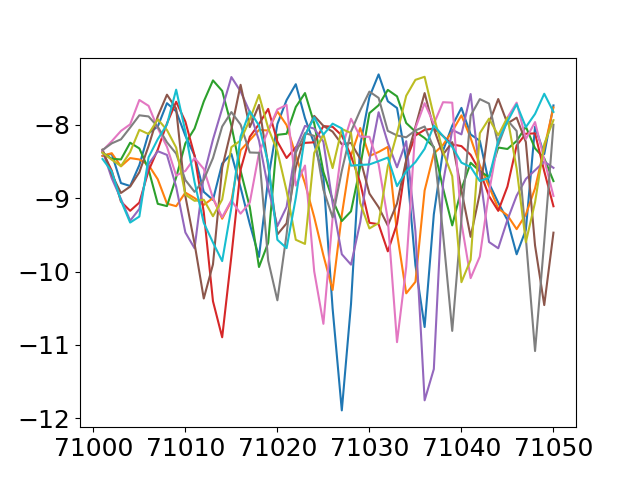

In [15]:
plt.figure()
for traj in trajs:
    plt.plot(traj[:,0],traj[:,1])

In [21]:
stds = np.std(trajss[...,1], axis=1)
stds.shape

(10, 50)

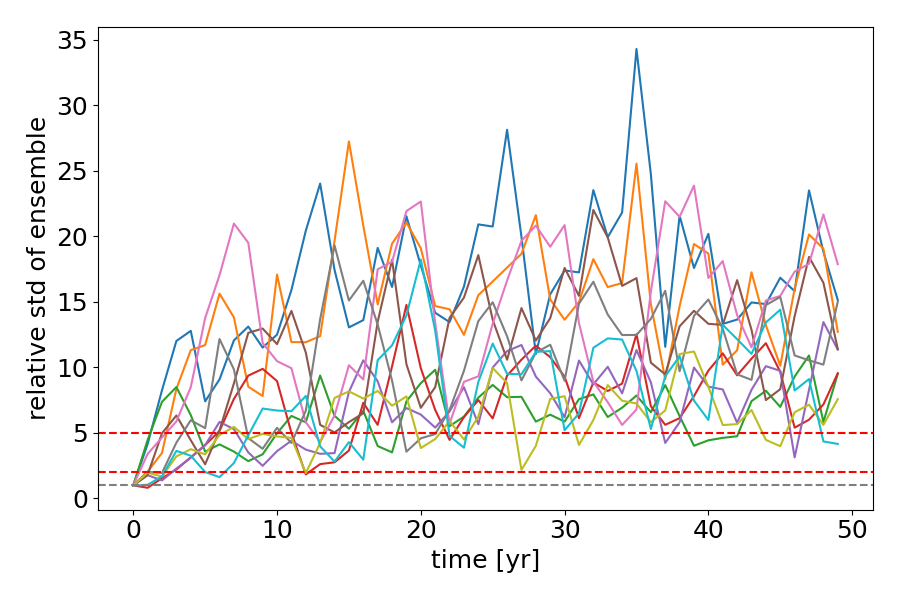

In [26]:
fig,ax = plt.subplots(figsize=(9,6))
for std in stds:
    plt.plot(std/std[0])
    
plt.axhline(1, color='grey', linestyle='dashed')
plt.axhline(2, color='red', linestyle='dashed')
plt.axhline(5, color='red', linestyle='dashed')
    
plt.xlabel('time [yr]')
plt.ylabel('relative std of ensemble')

fig.tight_layout()